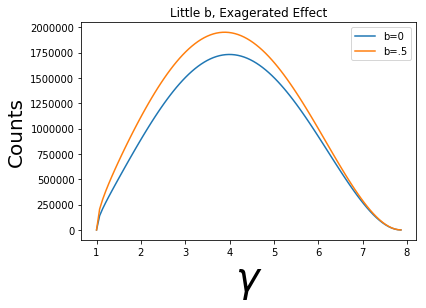

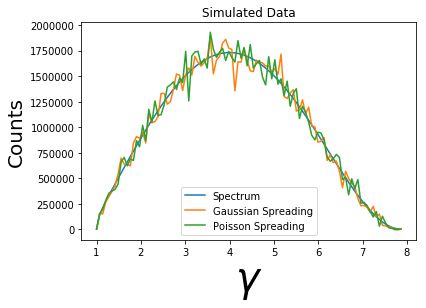

In [8]:
# Cell showing that the spectrum construction is working. 


%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt


# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

# --------------------Input Parameters--------------------#

N = 1e8  # number of counts (simulated).
n1 = 1  # normalization constant for fit
n2 = .5  # normalization constant for fit
n_x = 100  # number of energy bins

# ---------------------------------------------------------#


def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in eV


x = np.linspace(1, e0, n_x)  # n_x linearly spaced numbers

f_st = spect_data(x, e0)  # standard spectrum
sum1 = sum(f_st)  # using the sum of the list to normalize.
f_st = f_st * N / sum1 
y_fit = n1*f_st + n2*f_st/x  # lil_b effected spectrum
sum2 = sum(y_fit)  # using the sum of the list to normalize. 

y_gdata = np.around(N/sum1*np.random.normal(spect_data(x, e0), spect_data(x, e0) ** .5))  # Normalizing and rounding (gaussian)
y_pdata = np.around(N/sum1*np.random.poisson(spect_data(x, e0)))  # Normalizing and rounding (poisson)


plt.plot(x, f_st, x, y_fit)  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Little b, Exagerated Effect")
plt.gca().legend(('b=0', 'b=.5'))

plt.show()

plt.plot(x, f_st, x, y_gdata, x, y_pdata)  # Plotting the simulated data
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Simulated Data")
plt.gca().legend(('Spectrum', 'Gaussian Spreading', 'Poisson Spreading'))

plt.show()


this should be exactly N -> 10000000000.000017
percentage of P that is nan: 0.0


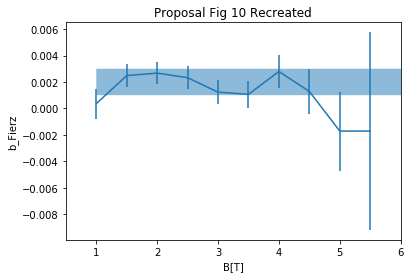

In [1]:
# Here I am parsing the data by field and redoing Alejandro's Fig. 10 in our proposal.
# Note that NR denotes Numerical Recipes so that you can follow along with the math. 

%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import math


# -------------------Physical (or natural) Constants -------------------#

me = 5.11e5  # electron mass in eV/c^2
c = 3*10**8
pi= math.pi


# --------------------Input Parameters--------------------#

N = 1e10    # number of counts (simulated).
lil_b = 2e-3 # little b value
n_x = 1000  # number of energy bins in entire spectrum 
n_M = 2    # number of fit parameters 


# -----------------Constructing the Standard (b=0) beta spectrum-------------------------#

def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma, or total energy in units of me.


x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum

def y_fit(A,B):
    return A*f_st + B*f_st/x # This function is used to create fake data and to fit. lil_b = B/A. 


# --------------------Normalizing--------------------#

n1_init = 1000   # I use this to create an initital spectrum and then renormalize to get N total counts.  
norm = sum(y_fit(n1_init,lil_b*n1_init))  # norm is the total number of "counts" initially.

C_norm = n1_init*N/norm  # renormalization constant

n1 = C_norm   
n2 = lil_b*C_norm    


print('this should be exactly N ->', sum(y_fit(n1,n2))) # Verifying that the normalization worked. 



# ----------------Setting up the different arrays necessary for the fitting  ------------------------#

n_B = 10 # Sets number of different field strengths we will run with 

P = np.zeros(shape=(n_M,n_B)) # Fit parameters n1, n2 for each field configuration
P_unc = np.zeros(shape=(n_M,n_B)) # Fit uncertainies for each field configuration (NR 15.4.15)
b_fit = np.zeros(shape=(n_B))  # b (from n1, n2) for each field configuration
b_fit_unc = np.zeros(shape=(n_B)) # uncertainty in b for for each field configuration


# --------------------Faking Data --------------------#

y_gdata = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) # Gaussian random data. 


# --------------------Boundries in Energy for different fields and a fixed 18-24 Ghz bandwidth --------------------#

E_boundries_high = np.zeros(shape=(n_B))  # Upper/Lower bounds in energy for a given B field 
E_boundries_low = np.zeros(shape=(n_B))  

ftoE = c**2/(me*2*pi)  # Note that this is more aptly f to gamma b/c E is measured in units of m_e
B_start = 1 # B field starting at 1 T
B_inc = .5  # B field increased in units of .5 T
f_min = 18e9 # GHz
f_max = 24e9 # GHz


h = 0
while h < n_B:
    E_boundries_high[h] = ftoE*(B_start + h*B_inc)/f_min
    E_boundries_low[h] = ftoE*(B_start + h*B_inc)/f_max  
    h += 1 

    
E_boundries_high_indicies= np.rint((E_boundries_high - 1)*n_x/(e0-1)) # Indicies of the energy bounds
E_boundries_low_indicies= np.rint((E_boundries_low - 1)*n_x/(e0-1))   
# Note that there is overlap in energies between fields especially at higher fields

# There can be energies at these fields and bandwidth beyond our endpoint energy.
# Here I am changing those bounds to just be the last bin of our spectrum. 
g = 0 
while g< n_B: 
    if E_boundries_high_indicies[g] >= n_x:
        E_boundries_high_indicies[g] = n_x-1
    if E_boundries_low_indicies[g] >= n_x:
        E_boundries_low_indicies[g] = n_x-1
    g += 1


# --------------------General Linear Least Squares -> n1, n2 -> lil_b (for each field strength) --------------------#

j = 0 
while j < n_B: 
    
    # --------------------Parcing up the relevant arrays --------------------#
    x_temp = x[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    f_st_temp = f_st[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    y_gdata_temp = y_gdata[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    n_x_temp = len(x_temp)
    

    # --------------------Putting together the Toolbox: NR 15.4.1-3--------------------#

    X = np.array([f_st_temp,f_st_temp/x_temp]).transpose() # basis functions. 
    sigma = y_gdata_temp**.5  # Assuming gaussian random data
   

    # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
    A = np.zeros(shape=(n_x_temp,n_M))
    
    i=0
    while i < n_M:
        A[:,i] = X[:,i]/sigma
        i += 1
    
    b_matrix = y_gdata_temp/sigma
    alpha = A.transpose() @ A  #NR 15.5.8
    beta = A.transpose() @ b_matrix   #NR 15.5.9

    P[:,j] = np.linalg.inv(alpha) @ beta

    
    
    # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
    i=0
    while i < n_M:
        P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
        i += 1
    b_fit[j] = P[1,j]/P[0,j] # b = n2/n1
    
    # below is the uncertainty in b using error propigation with a non-zero covariance 
    b_fit_unc[j] = ((P[1,j]/P[0,j])**2 *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2) 
                    - 2*(P[1,j]/P[0,j]**3)*np.linalg.inv(alpha)[0,1])**.5 
    j += 1 

    
# --------------------Debugging to see if any of the fits failed --------------------#        

#This prints the number of nan pairs I get in my P matrix
print("percentage of P that is nan:",np.argwhere(np.isnan(P)).shape[0]/(2*n_B))

    
# --------------------Recreating Alejandro's Fig 10--------------------#   

B_spect = np.zeros(shape = n_B)  # Array for the x axis of the plot 
j = 0
while j < n_B:
    B_spect[j] = B_start + j*B_inc
    j += 1 
    

plt.figure()
plt.fill_between(x, .001, .003, alpha=0.5)
plt.xlim(.5,6)
plt.errorbar(B_spect, b_fit, b_fit_unc)
plt.title("Proposal Fig 10 Recreated")    
plt.ylabel('b_Fierz')
plt.xlabel('B[T]')
plt.show()   


# # -------------------- Plotting n1,n2 (histogram)  --------------------# 

# k = 0
# while k < n_M: 
#     plt.hist(P[k,:]*norm/(n1_init*N), bins=50)
#     plt.ylabel('Frequency')
#     plt.xlabel('Parameter n%d' % k)
#     plt.show()
#     k += 1 



